#### 필요한 데이터와 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [2]:
train = pd.read_csv('c:/data/titanic/train.csv')
test = pd.read_csv('c:/data/titanic/test.csv')
IDtest = test['PassengerId']

#### 이상치 탐지 - Tukey method
- IQR = 3분위수 - 1분위수
일 때, (Q1 - 1.5*IQR)보다 작거나, (Q3 + 1.5*IQR) 보다 큰 데이터에 대해서 이상치로 간주한다.

- collections 라이브러리의 Counter메소드는 인자로 받은 리스트의 원소를 키로, 개수를 밸류로 하는 딕셔너리로 반환한다.

In [3]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    
    return multiple_outliers

Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

In [4]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [5]:
# 탐지한 이상값을 drop한다.
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

In [6]:
# 범주형 변수 변환시 같은 수치를 얻기 위해서 트레이닝/테스트 데이터를 합쳐준다.
# 합친 데이터를 분리할 때, 미리 설정해놓은 훈련데이터의 수만큼 분할할 수 있도록 훈련데이터의 개수를 저장해놓는다.
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

#### 결측치와 널값 체크

In [7]:
dataset = dataset.fillna(np.nan)

dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Feature analysis

#### 수치형 자료
- 먼저 수치형 자료들에 대해서 상관계수를 살펴본다.
- 그 다음으로 변수 하나하나씩 종속변수와 함께 살펴본다.

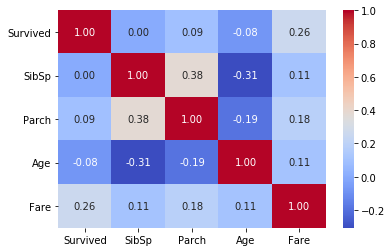

In [10]:
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(), annot=True, fmt = '.2f', cmap='coolwarm')

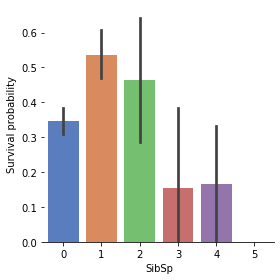

In [11]:
# SibSp
g = sns.catplot(x = 'SibSp', y='Survived',data=train,kind='bar', height=4, palette = 'muted')

g.despine(left=True)
g = g.set_ylabels('Survival probability')

- SibSp의 수가 많을수록 생존률이 떨어지는 듯 보인다.
- 0~2의 수를 가질 때 생존률이 높다.

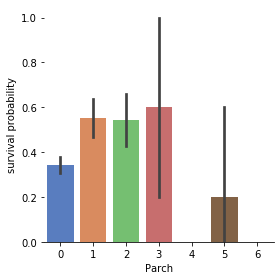

In [12]:
#Parch
g = sns.catplot(x = 'Parch', y= 'Survived', data =train, kind='bar', height= 4, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

- 가족의 수가 적을수록 생존률이 높은 경향이 있다.
- 수치 3에 표준편차가 크다.

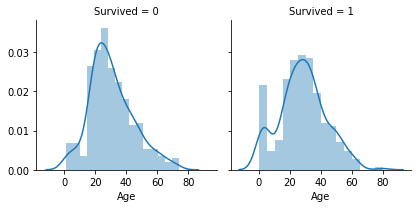

In [13]:
# Age
g = sns.FacetGrid(train, col = 'Survived')
g = g.map(sns.distplot, 'Age')

- 나이 분포는 생존의 클래스마다 다른 양상을 보인다. 60-80세의 경우, 생존률이 낮았고 어린 승객의 경우 생존률이 높았음을 확인할 수 있다.

- 위 상관계수 히트맵에서 나이가 생존과 관련이 크게 없었다고 해도(-0.08) 특정 나이 범주에서 생존을 더/덜한 케이스를 위의 분포로 확인할 수 있다.

- 매우 어린 승객은 생존률이 높았다.

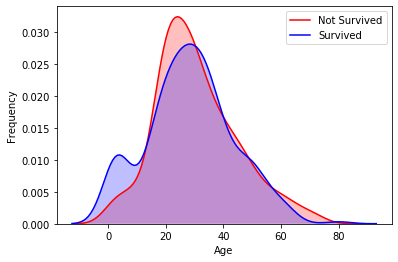

In [14]:
# 나이 분포 살펴보기
# 생존의 두 경우를 결측치가 없는 데이터들을 대상으로 살펴보자.
g = sns.kdeplot(train['Age'][(train['Survived']==0)&(train['Age'].notnull())], color='Red', shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1)&(train['Age'].notnull())], color = 'Blue', shade=True)

g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

In [15]:
# Fare
dataset['Fare'].isnull().sum()

1

In [16]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

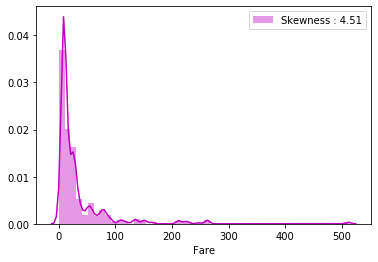

In [17]:
g = sns.distplot(dataset['Fare'], color = 'm', label = 'Skewness : %.2f'%dataset['Fare'].skew())
g = g.legend(loc='best')

fare의 분포는 굉장히 왜도가 높다. 이와같은 경우, 왜도를 줄이기 위해 로그 변환을 해주는 것이 좋다.

In [18]:
dataset['Fare'] = dataset['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

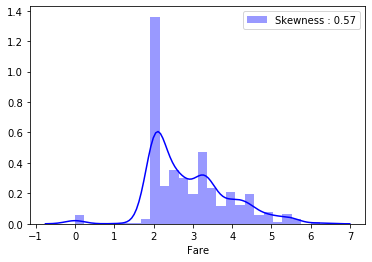

In [19]:
g = sns.distplot(dataset['Fare'], color = 'b', label = 'Skewness : %.2f'%(dataset['Fare'].skew()))
g.legend(loc='best')

### 범주형 변수 살펴보기

#### Sex

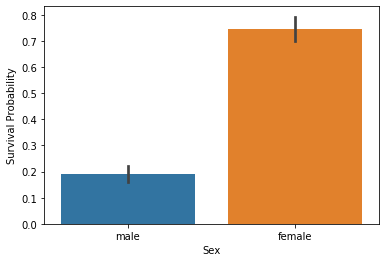

In [20]:
g = sns.barplot(x = 'Sex', y = 'Survived', data = train)
g = g.set_ylabel('Survival Probability')

In [21]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


- 남성이 여성보다 생존률이 낮은 것이 자명하다.
- Sex 피쳐는 생존 예측에 중요한 변수일 것이다.

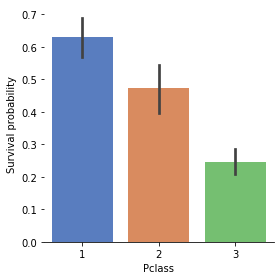

In [22]:
# Pclass
g = sns.catplot(x='Pclass', y='Survived', data = train, kind='bar', height = 4, palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

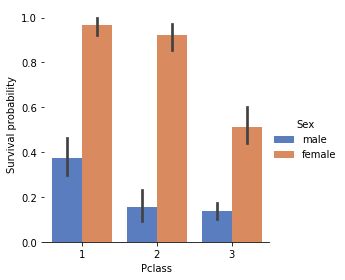

In [23]:
# Sex 별로 살펴보기
g = sns.catplot(x='Pclass', y = 'Survived', hue = 'Sex', data = train, height = 4, kind = 'bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

- 생존률이 클래스 3에서 같지 않다. 클래스가 내려갈수록 생존률이 낮아진다.(남녀 상관 없이)

In [24]:
# Embarked
dataset['Embarked'].isnull().sum()

2

In [25]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

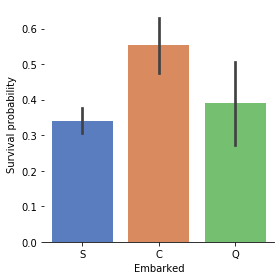

In [26]:
g = sns.catplot(x= 'Embarked', y= 'Survived', data = train, height = 4, kind = 'bar', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Survival probability')

- C 선착장에서 탄 승객들이 생존률이 더 높게 나타난다.
- C에 탄 사람들이 높은 클래스의 티켓을 가진 승객일 것이라는 가정을 해보자. (C - Q - S 순)

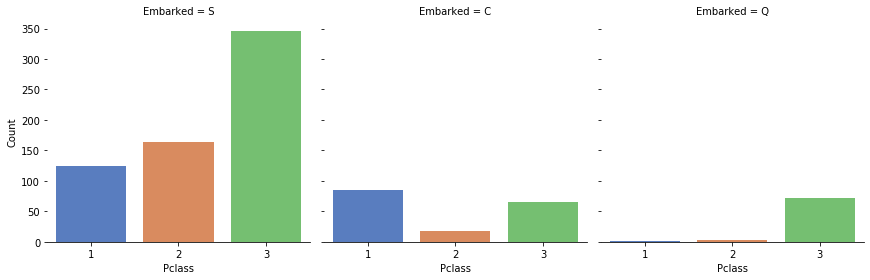

In [27]:
g = sns.catplot('Pclass',col = 'Embarked', data = train, height=4, kind = 'count', palette = 'muted')
g.despine(left=True)
g = g.set_ylabels('Count')

- S에 3등석 승객이 굉장히 많은 것을 알 수 있다. 이에반해 C에는 1등석 승객이 상대적으로 많다. Q는 대부분이 3등석이다.(그러나 S에 3등석 승객이 굉장히 많으므로 생존률이 낮은 것 같다.

### 결측치 다루기
- Age의 결측치를 채우기 전에, 위에서 살펴본 age 피쳐의 분포를 떠올려보자.(어리면 생존률이 높고 나이가 많으면 생존률이 낮았다) 
- 나이 구간에 따른 특성이 존재했으므로, 이 특성을 그대로 살려야 한다.
    - 나이와 연관된 피쳐를 찾아서 그 피쳐들이 가진 특성에 따라 나이를 추정할 것이다.

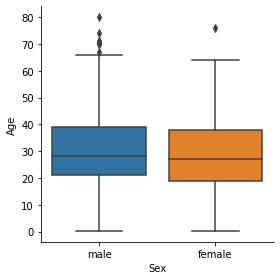

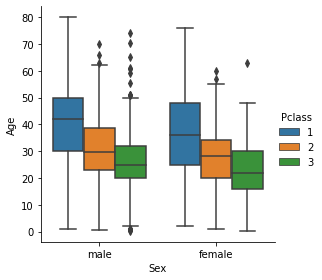

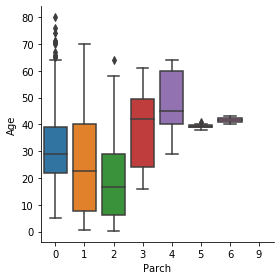

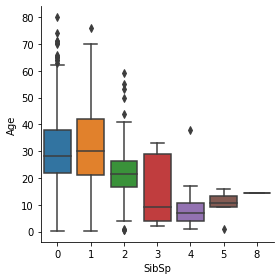

In [28]:
# Age와 연관이 있어보이는 다른 변수들을 함께 고려해보자.

g = sns.catplot(y='Age',x='Sex',data=dataset,kind='box', height=4)
g = sns.catplot(y='Age',x='Sex',hue='Pclass',data = dataset, kind='box', height=4)
g = sns.catplot(y='Age',x='Parch',data = dataset, kind='box', height=4)
g = sns.catplot(y='Age',x='SibSp',data = dataset, kind='box', height=4)

- 성별에 따른 나이 분포는 비슷하다.
- 클래스가 낮아질수록 나이가 어려진다.
- 자녀/부모가 많을수록 나이가 많다
- 형제/배우자가 많을수록 나이가 어리다.

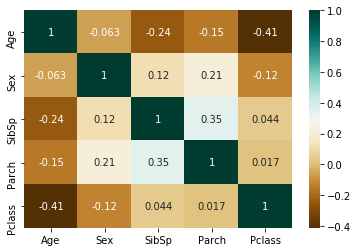

In [29]:
# 성별을 숫자로 바꿔주자.
dataset['Sex'] = dataset['Sex'].map({'male':0, 'female':1})

g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(), cmap='BrBG', annot = True)

위에서 Age, SibSp, Parch, Pclass가 연관되어있다고 파악했으므로, 이 피쳐들이 공유하는 나이대로 나이를 추정할 것이다.
- 결측값인 승객과 SibSp, Parch, Pclass가 같은 다른 승객의 나이의 중위수로 결측값을 처리할 것.
    - dataset['SibSp'] == dataset.iloc[0]['SibSp'] 은 조건에 맞는 행에 True를 반환한다.

In [32]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp'] == dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[i]['Parch'])&(dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    
    if not np.isnan(age_pred):
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med

In [33]:
dataset.iloc[0]['SibSp']

1

In [34]:
dataset['Age'][((dataset.iloc[i]['SibSp'])&(dataset['Parch']==dataset.iloc[0]['Parch'])&(dataset['Pclass']==dataset.iloc[0]['Pclass']))].median()

25.0

In [35]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3669: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


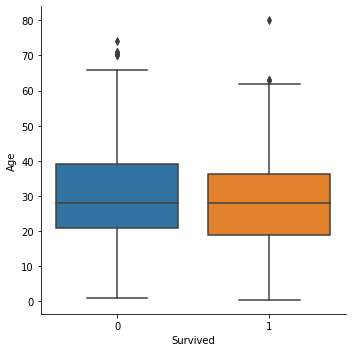

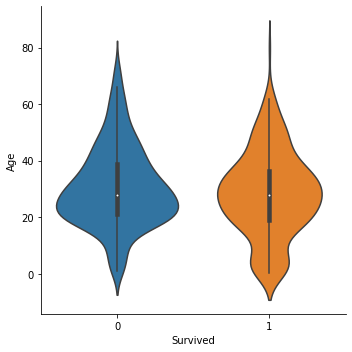

In [36]:
g = sns.factorplot(x='Survived', y='Age',data = train, kind='box')
g = sns.factorplot(x='Survived', y='Age',data = train, kind='violin')

전체적인 분포를 해치지 않으면서도(위 그래프)  
그룹별 생존률 특성을 보존했다.(아래 그래프)

### Feature engineering

In [37]:
dataset['Name'].head()[0]

'Braund, Mr. Owen Harris'

이름을 살펴보면 title을 가지고 있는데, 타이틀에 따라 다르게 구조되거나 그러지 않았을까?(가정)

In [38]:
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]

dataset['Title'] = dataset_title
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

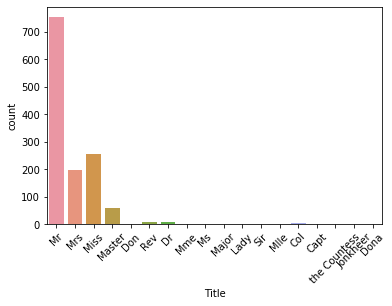

In [39]:
g = sns.countplot(x='Title', data = dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

In [40]:
# 여러개의 title을 4개로 그룹지어보자.
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0,"Miss":1,"Ms":1,"Mme":1,"Mlle":1,"Mrs":1,"Mr":2,"Rare":3})
dataset['Title'] = dataset['Title'].astype(int)

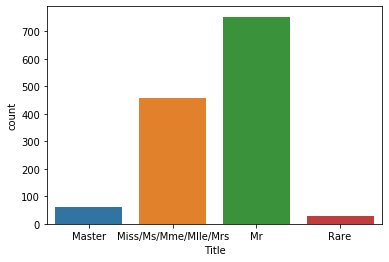

In [41]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

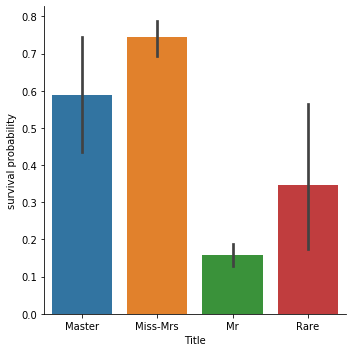

In [42]:
g = sns.catplot(x='Title', y= 'Survived', data = dataset, kind = 'bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('survival probability')

Rare 타이들의 생존률이 높다는 점이 흥미롭다.

Name feature는 사용하지 않으므로 드랍하도록 하자.

In [43]:
dataset.drop(labels=['Name'], axis = 1, inplace = True)

가족의 수가 많으면 생존률이 낮아짐을 확인하였다. 따라서, SibSp + Parch를 합친 Fsize 열을 만들어 경향을 확인해보도록 하자.

In [44]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

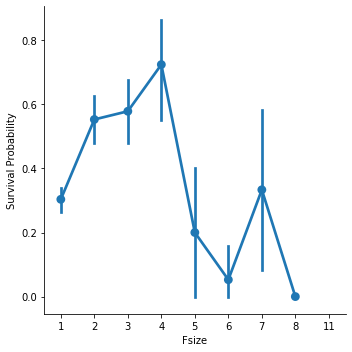

In [45]:
g = sns.catplot(x='Fsize', y='Survived', data=dataset, kind='point')
g = g.set_ylabels('Survival Probability')

가족의 크기가 클수록 생존률이 낮음을 확인할 수 있다.
가족의 크기를 4가지 범주로 나누어 확인해보면 어떨까?(아이디어)

In [46]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s ==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s ==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >=5 else 0)

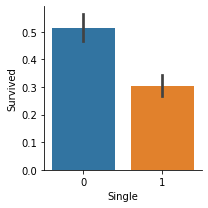

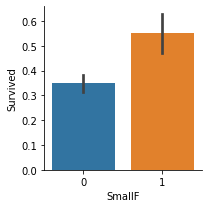

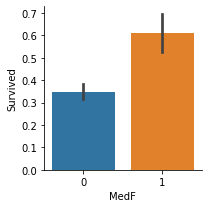

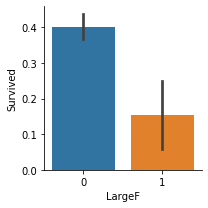

In [47]:
sns.catplot(x='Single',y='Survived',data=dataset, kind='bar', height=3)
sns.catplot(x='SmallF',y='Survived',data=dataset, kind='bar', height=3)
sns.catplot(x='MedF',y='Survived',data=dataset, kind='bar', height=3)
sns.catplot(x='LargeF',y='Survived',data=dataset, kind='bar', height=3)

In [48]:
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'], prefix = 'Em')

In [49]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


In [50]:
# Cabin
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [51]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [52]:
dataset['Cabin'].isnull().sum()

1007

In [53]:
dataset['Cabin'][dataset['Cabin'].notnull()].dtype

dtype('O')

In [54]:
# Cabin nulber의 앞 알파벳만 가져오고, 결측값은 X로 표시하자.
dataset['Cabin'] = ([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

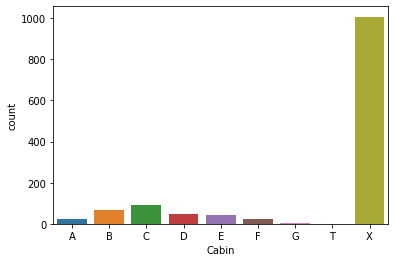

In [56]:
g = sns.countplot(dataset['Cabin'], order=['A','B','C','D','E','F','G','T','X'])

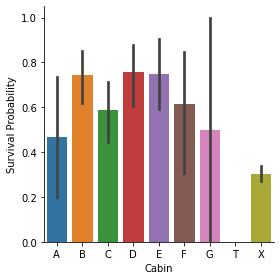

In [57]:
g = sns.catplot(y='Survived', x='Cabin',data=dataset, kind='bar', order = ['A','B','C','D','E','F','G','T','X'], height= 4)
g = g.set_ylabels('Survival Probability')

- 표준편차가 커서 다른 객실들간의 비교가 힘들다.(객실 샘플수가 적은 이유로 인해)
- 그러나 객실 정보가 있는 승객들이 그렇지 않은 승객들보다 생존률이 더 높음을 알 수 있다.

In [58]:
dataset = pd.get_dummies(dataset, columns=['Cabin'], prefix='Cabin')

#### 티켓
- 티켓의 알파벳이 같으면 클래스나 생존률이 비슷할 것이다. 티켓의 알파벳 부분만 남겨보도록 한다.

In [59]:
Ticket = []

for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.',"").replace('/',"").strip().split(' ')[0])
    else:
        Ticket.append('X')

dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [60]:
dataset = pd.get_dummies(dataset, columns=['Ticket'], prefix='T')

In [61]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='Pc')

In [62]:
dataset.drop(labels = ['PassengerId'], axis=1, inplace=True)

#### MODELING

In [65]:
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis=1, inplace=True)

In [68]:
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'], axis = 1)

In [90]:
kfold = StratifiedKFold(n_splits = 10)

random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

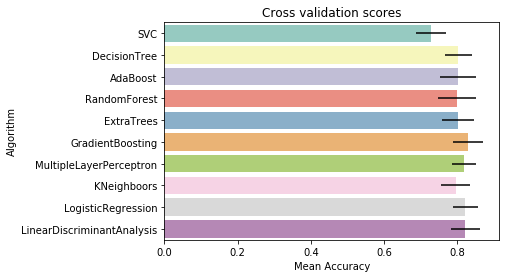

In [91]:
g = sns.barplot('CrossValMeans','Algorithm',data=cv_res,palette='Set3',orient='h',xerr=cv_std)
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

SVC, AdaBoost, RandomForest, ExtraTrees & GradientBoosting

#### Hyperparameter Tunning for the Best models

In [97]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state = 7)
ada_param_grid = {'base_estimator__criterion':['gini','entropy'],
                 'base_estimator__splitter':['best','random'],
                 'algorithm':['SAMME','SAMME.R'],
                 'n_estimators':[1,2],
                 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3,1.5]}
gsadaDTC = GridSearchCV(adaDTC, param_grid = ada_param_grid, cv = kfold, scoring = 'accuracy', verbose =1, n_jobs = 4)
gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  68 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    5.4s finished


In [99]:
gsadaDTC.best_score_

0.82073544433095

In [102]:
# ExtraTreeClassifier

ExtC = ExtraTreesClassifier()

ex_param_grid = {'max_depth':[None],
                'max_features':[1,3,10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap':[False],
                'n_estimators':[100,300],
                'criterion':['gini']}

gsExtC = GridSearchCV(ExtC,param_grid=ex_param_grid,cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.9s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   49.7s finished


0.8308861082737489

In [104]:
# Random Forest Classifier

RFC = RandomForestClassifier()

rf_param_grid = {'max_depth':[None],
                'max_features':[1,3,10],
                'min_samples_split':[2,3,10],
                'min_samples_leaf':[1,3,10],
                'bootstrap':[False],
                'n_estimators':[100,300],
                'criterion':['gini']}

gsRFC = GridSearchCV(RFC, param_grid = rf_param_grid, cv = kfold, scoring = 'accuracy', n_jobs = 4, verbose = 1)

gsRFC.fit(X_train, Y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   19.6s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   44.7s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   54.5s finished


0.8365551583248212

In [108]:
GBC = GradientBoostingClassifier()
gb_param_grid={'loss':['deviance'],
              'n_estimators':[100,200,300],
              'learning_rate':[0.1,0.05,0.01],
              'max_depth':[4,8],
              'min_samples_leaf':[100,150],
              'max_features':[0.3,0.1]
              }

gsGBC = GridSearchCV(GBC,param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)

gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   10.3s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   21.7s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   33.4s finished


0.8308733401430031

In [109]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   14.8s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   25.7s finished


0.8331332992849847

#### 학습곡선

In [118]:
def plot_learning_curve(estimator, title, X,y,ylim=None,cv=None,n_jobs=-1, train_sizes=np.linspace(0.1,1,5)):
    plt.figure(figsize=(6,3))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color = 'r')
    
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label = 'Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color = 'g', label = 'Cross-validation score')
    
    plt.legend(loc='best')
    return plt

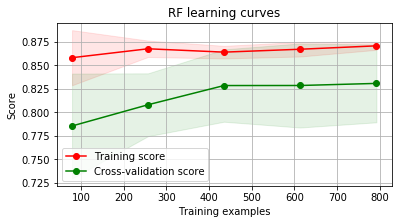

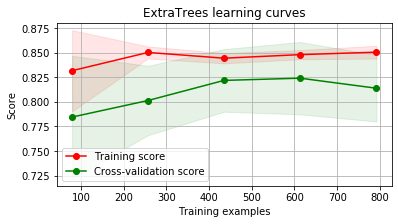

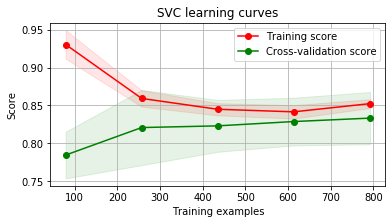

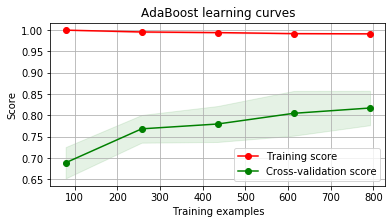

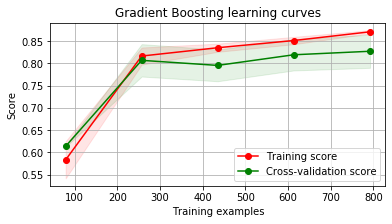

In [119]:
g = plot_learning_curve(gsRFC.best_estimator_,'RF learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,'ExtraTrees learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,'SVC learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,'AdaBoost learning curves', X_train, Y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,'Gradient Boosting learning curves', X_train, Y_train, cv=kfold)

#### Feature importance of 트리기반 분류기

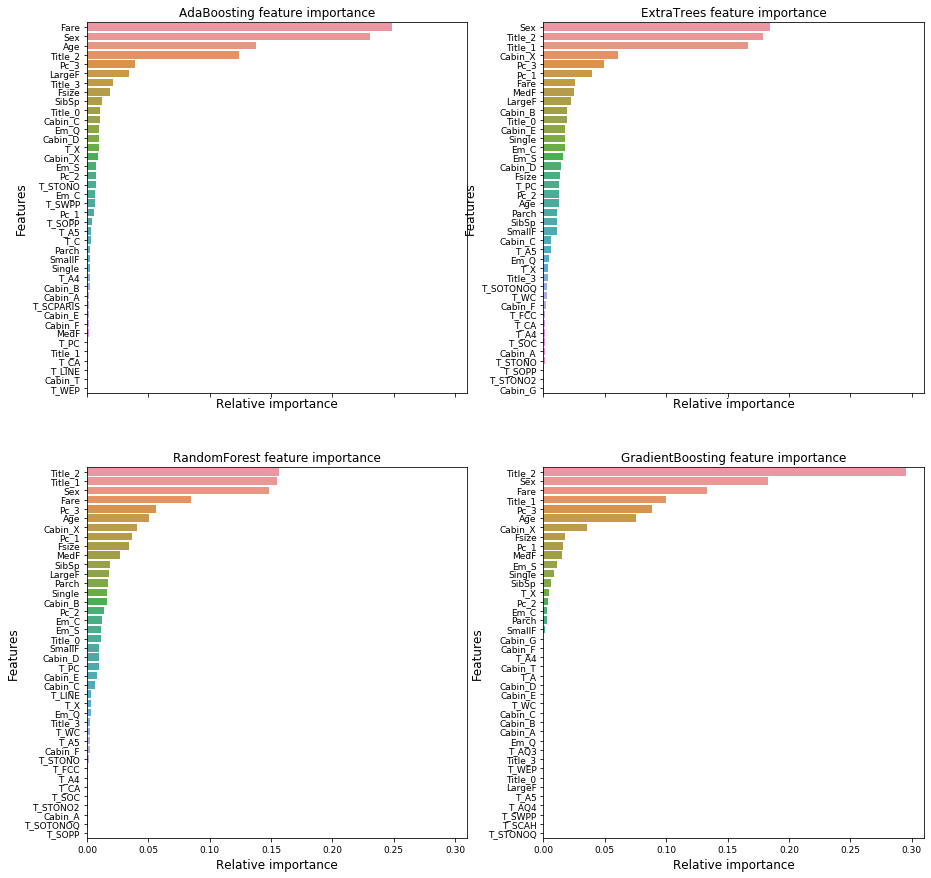

In [121]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex = 'all', figsize = (15,15))

names_classifiers = [('AdaBoosting', ada_best),('ExtraTrees',ExtC_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best)]

nclassifier = 0

for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x = classifier.feature_importances_[indices][:40], orient = 'h', ax = axes[row][col])
        
        g.set_xlabel('Relative importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+' feature importance')
        nclassifier += 1

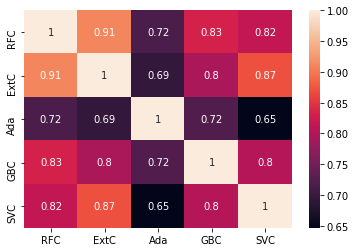

In [139]:
# 각 분류기가 예측한 값들을 한데 모아서 서로간의 상관관계를 살펴보도록 하자.

test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

- AdaBoost가 다소 상관관수가 다른 것들에 비해 낮지만 이렇게 5개의 분류기는 비슷한 양상으로 추측을 한다.

- 이것들로 voting classifier를 구성해보자.

In [143]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [144]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

In [145]:
results

,PassengerId,Survived
0,892,0.0
1,893,0.0
2,894,0.0
3,895,0.0
4,896,1.0
...,...,...
413,1305,0.0
414,1306,1.0
415,1307,0.0
416,1308,0.0
